# 复赛数据
在给出若干日内来自某成熟国家xx的部分用户的点击购买数据，以及来自某待成熟国家yy和待成熟国家zz的A部分用户的点击购买数据，以及国家yy和zz的B部分用户的截止最后一条购买数据之前的所有点击购买数据，让参赛人预测B部分用户的最后一条购买数据。

商品属性表: 商品的类目id、店铺id以及加密价格，其中价格的加密函数f(x)为一个单调增函数。
训练数据: 给出xx国的用户的点击、购买数据和yy国、zz国的A部分用户的点击、购买数据。
测试数据: 给出yy国、zz国的B部分用户的最后一条购买数据之前的点击购买数据.

训练数据和测试数据的数据结构是一样的，其中各字段含义如下：
country_id: 买家国家id, 只有'xx','yy','zz'三种取值
buyer_admin_id: 买家id
item_id: 商品id
log_time: 商品详情页访问时间
irank: 每个买家对应的所有记录按照时间顺序的逆排序
buy_flag: 当日是否购买

数据集特点：
每个用户有若干条点击数据和至少1条购买数据 （但测试数据中该条购买记录可能未给出到选手）
每个用户的最后一条数据的buy_flag一定为1 （但测试数据中该条数据未给出到选手）
测试数据中每个用户的最后一条点击数据（也是购买数据）所对应的商品一定在训练数据中出现过.
可能存在少量跨国买家.

要求选手提交的数据
关于yy国、zz国的B部分用户每个用户的最后一条购买数据的预测Top30

提交说明：
选手提交的CSV文件, 其格式应如下：
buyer_admin_id,predict 1,predict 2,…,predict 30
其中buyer_admin_id为买家id, predict 1 ,…, predict 30 为预测用户购买商品Top30的item_id依概率从高到低排序，不含表头，例如：

1233434,4354,23432,6546,...,91343

2132133,154,20987,34349,...,78772



评估方法：
MRR(Mean Reciprocal Rank)： 首先对选手提交的表格中的每个用户计算用户得分
$$
score\left(buyer\right) = \sum_{k=1}^{30}\frac{s\left(buyer,k\right)}{k}
$$

其中, 如果选手对该buyer的预测结果predict k命中该buyer的最后一条购买数据则$s\left(buyer,k\right)=1$; 否则$s\left(buyer,k\right)=0$. 最终得分为所有这些buyer的平均值。


In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
%matplotlib inline
import gc

import warnings
warnings.filterwarnings("ignore")

In [2]:
item = pd.read_csv('../data/Antai_AE/Antai_AE_round2_item_attr_20190813.csv')
train = pd.read_csv('../data/Antai_AE/Antai_AE_round2_train_20190813.csv')
test = pd.read_csv('../data/Antai_AE/Antai_AE_round2_test_20190813.csv')

In [3]:
item.isnull().any()

item_id       False
cate_id       False
store_id      False
item_price    False
dtype: bool

In [4]:
train.head()

,country_id,buyer_admin_id,item_id,log_time,irank,buy_flag
0,xx,1,7554,2018-04-19 10:59:56,79,0
1,xx,1,7937,2018-04-19 11:17:45,62,0
2,xx,1,7544,2018-04-18 22:19:30,81,0
3,xx,1,7559,2018-04-18 22:15:27,82,0
4,xx,1,7554,2018-04-19 11:28:34,46,0


In [5]:
test.head()

,country_id,buyer_admin_id,item_id,log_time,irank,buy_flag
0,zz,186,5759164,2018-04-16 05:11:47,37,0
1,zz,186,2321601,2018-04-16 04:57:35,48,0
2,zz,186,5244747,2018-04-17 12:24:43,2,0
3,zz,186,2136020,2018-04-17 11:53:41,8,0
4,zz,186,2137602,2018-04-16 04:57:36,47,0


In [6]:
train["log_time"].min(), train["log_time"].max()

('2018-04-16 00:00:00', '2018-04-30 23:59:00')

In [7]:
test["log_time"].min(), test["log_time"].max()

('2018-04-16 00:00:05', '2018-04-30 23:52:06')

In [8]:
train["country_id"].unique(), test["country_id"].unique()

(array(['xx', 'zz', 'yy'], dtype=object), array(['zz', 'yy'], dtype=object))

In [9]:
train["irank"].min(), test["irank"].min()

(1, 2)

In [10]:
train["buyer_admin_id"].nunique(), test["buyer_admin_id"].nunique()

(614960, 9844)

In [11]:
train["irank"].max(), test["irank"].max()

(264473, 39848)

In [12]:
train["buy_flag"].unique(), test["buy_flag"].unique()

(array([0, 1]), array([0, 1]))

In [13]:
train.isnull().any()

country_id        False
buyer_admin_id    False
item_id           False
log_time          False
irank             False
buy_flag          False
dtype: bool

In [14]:
test.isnull().any()

country_id        False
buyer_admin_id    False
item_id           False
log_time          False
irank             False
buy_flag          False
dtype: bool

In [15]:
train.groupby("buyer_admin_id").size().min(), test.groupby("buyer_admin_id").size().min()

(1, 1)

In [16]:
train.groupby("buyer_admin_id").size().max(), test.groupby("buyer_admin_id").size().max()

(264473, 39847)

In [17]:
pd.concat([train, test]).groupby("buyer_admin_id")["country_id"].nunique().value_counts()

1    624804
Name: country_id, dtype: int64

In [18]:
df = pd.concat([train.assign(is_train=1), test.assign(is_train=0)])
del train, test; gc.collect()

df['log_time'] = pd.to_datetime(df['log_time'])
df['date'] = df['log_time'].dt.date
df['day'] = df['log_time'].dt.day
df['hour'] = df['log_time'].dt.hour

df = pd.merge(df, item, how='left', on='item_id')

In [19]:
df.head()

,country_id,buyer_admin_id,item_id,log_time,irank,buy_flag,is_train,date,day,hour,cate_id,store_id,item_price
0,xx,1,7554,2018-04-19 10:59:56,79,0,1,2018-04-19,19,10,1467.0,9682.0,2067.0
1,xx,1,7937,2018-04-19 11:17:45,62,0,1,2018-04-19,19,11,1467.0,9541.0,1865.0
2,xx,1,7544,2018-04-18 22:19:30,81,0,1,2018-04-18,18,22,1467.0,9682.0,1604.0
3,xx,1,7559,2018-04-18 22:15:27,82,0,1,2018-04-18,18,22,1467.0,9682.0,2067.0
4,xx,1,7554,2018-04-19 11:28:34,46,0,1,2018-04-19,19,11,1467.0,9682.0,2067.0


In [20]:
memory = df.memory_usage().sum() / 1024**2 
print('Before memory usage of properties dataframe is :', memory, " MB")

dtype_dict = {'buyer_admin_id' : 'int32', 
              'item_id' : 'int32', 
              'store_id' : pd.Int32Dtype(),
              'irank' : 'int16',
              'item_price' : float,
              'cate_id' : pd.Int16Dtype(),
              'is_train' : 'int8',
              'day' : 'int8',
              'hour' : 'int8',
              'country_id': str,
              'date': str
             }

df = df.astype(dtype_dict)
memory = df.memory_usage().sum() / 1024**2 
print('After memory usage of properties dataframe is :', memory, " MB")

Before memory usage of properties dataframe is : 5631.612686157227  MB
After memory usage of properties dataframe is : 3469.475672721863  MB


In [21]:
df.isnull().any()

country_id        False
buyer_admin_id    False
item_id           False
log_time          False
irank             False
buy_flag          False
is_train          False
date              False
day               False
hour              False
cate_id            True
store_id           True
item_price         True
dtype: bool

In [22]:
df[['store_id', 'item_price', 'cate_id']].min()

store_id      1.0
item_price    1.0
cate_id       1.0
dtype: float64

In [23]:
# for col in ['store_id', 'item_price', 'cate_id']:
#     df[col] = df[col].fillna(0).astype(np.int32).replace(0, np.nan)
# df.to_hdf('../data/train_test_round2.h5', key='df', mode='w')
# del df; gc.collect()

In [24]:
# %%time
# df = pd.read_hdf('../data/train_test_round2.h5', key='df')

In [25]:
# del df; gc.collect()

In [26]:
# %%time
# train = pd.read_csv('../data/Antai_AE/Antai_AE_round2_train_20190813.csv')
# test = pd.read_csv('../data/Antai_AE/Antai_AE_round2_test_20190813.csv')
# item = pd.read_csv('../data/Antai_AE/Antai_AE_round2_item_attr_20190813.csv')
# del train, test; gc.collect()

# data content

In [27]:
df.head()

,country_id,buyer_admin_id,item_id,log_time,irank,buy_flag,is_train,date,day,hour,cate_id,store_id,item_price
0,xx,1,7554,2018-04-19 10:59:56,79,0,1,2018-04-19,19,10,1467,9682,2067.0
1,xx,1,7937,2018-04-19 11:17:45,62,0,1,2018-04-19,19,11,1467,9541,1865.0
2,xx,1,7544,2018-04-18 22:19:30,81,0,1,2018-04-18,18,22,1467,9682,1604.0
3,xx,1,7559,2018-04-18 22:15:27,82,0,1,2018-04-18,18,22,1467,9682,2067.0
4,xx,1,7554,2018-04-19 11:28:34,46,0,1,2018-04-19,19,11,1467,9682,2067.0


In [28]:
df.isnull().sum()

country_id            0
buyer_admin_id        0
item_id               0
log_time              0
irank                 0
buy_flag              0
is_train              0
date                  0
day                   0
hour                  0
cate_id           95958
store_id          95958
item_price        95958
dtype: int64

In [29]:
df.describe()

,buyer_admin_id,item_id,irank,buy_flag,is_train,day,hour,cate_id,store_id,item_price
count,5.272477e+07,5.272477e+07,5.272477e+07,5.272477e+07,5.272477e+07,5.272477e+07,5.272477e+07,52628809.0,52628809.0,5.262881e+07
mean,3.114219e+05,4.333457e+06,2.557213e+02,1.631748e-01,9.838060e-01,2.164609e+01,9.267078e+00,1681.968033,55937.194974,2.718526e+03
std,1.844761e+05,2.532043e+06,3.213240e+03,3.695250e-01,1.262211e-01,3.961407e+00,6.221378e+00,1058.869124,31055.458137,6.205391e+03
min,1.000000e+00,1.000000e+00,-3.276800e+04,0.000000e+00,0.000000e+00,1.600000e+01,0.000000e+00,1.0,1.0,1.000000e+00
25%,1.467390e+05,2.166051e+06,2.200000e+01,0.000000e+00,1.000000e+00,1.800000e+01,4.000000e+00,744.0,30288.0,2.950000e+02
50%,3.128890e+05,4.211300e+06,5.600000e+01,0.000000e+00,1.000000e+00,2.100000e+01,9.000000e+00,1769.0,57261.0,8.770000e+02
75%,4.740970e+05,6.461643e+06,1.420000e+02,0.000000e+00,1.000000e+00,2.500000e+01,1.300000e+01,2307.0,81254.0,2.301000e+03
max,6.266450e+05,9.167200e+06,3.276700e+04,1.000000e+00,1.000000e+00,3.000000e+01,2.300000e+01,4793.0,123617.0,5.080600e+04


In [30]:
df["irank"].min()

-32768

In [31]:
df["irank"].sort_values()

8803892   -32768
5657204   -32768
3618399   -32768
354146    -32768
1387808   -32768
           ...  
8755071    32767
3294630    32767
5039742    32767
4969069    32767
3618400    32767
Name: irank, Length: 52724767, dtype: int16

In [32]:
train = df['is_train']==1
test = df['is_train']==0

In [33]:
train_count = len(df[train])
print('训练集样本量是', train_count)
test_count = len(df[test])
print('测试集样本量是', test_count)
print('样本比例为：', train_count/test_count)

训练集样本量是 51870942
测试集样本量是 853825
样本比例为： 60.75125699060112


In [34]:
def groupby_cnt_ratio(df, col):
    if isinstance(col, str):
        col = [col]
    key = ['is_train', 'country_id'] + col
    
    cnt_stat = df.groupby(key).size().to_frame('count')
    ratio_stat = (cnt_stat / cnt_stat.groupby(['is_train', 'country_id']).sum()).rename(columns={'count':'count_ratio'})
    return pd.merge(cnt_stat, ratio_stat, on=key, how='outer').sort_values(by=['count'], ascending=False)

In [35]:
groupby_cnt_ratio(df, [])

count  count_ratio
is_train country_id                       
1        xx          42046596          1.0
         yy           5241393          1.0
         zz           4582953          1.0
0        yy            429319          1.0
         zz            424506          1.0

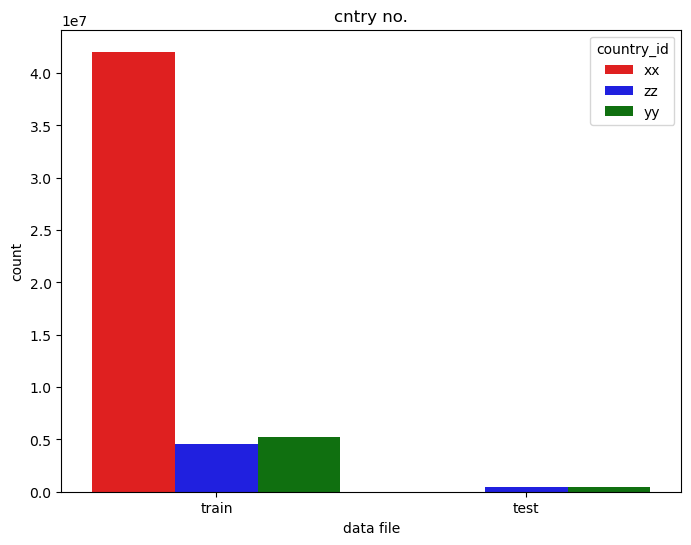

In [37]:
plt.figure(figsize=(8,6))
sns.countplot(x='is_train', data=df, palette=['red', 'blue', 'green'], hue='country_id', order=[1, 0])
plt.xticks(np.arange(2), ('train', 'test'))
plt.xlabel('data file')
plt.title('cntry no.');

In [38]:
print('训练集中用户数量',len(df[train]['buyer_admin_id'].unique()))
print('测试集中用户数量',len(df[test]['buyer_admin_id'].unique()))

训练集中用户数量 614960
测试集中用户数量 9844


In [39]:
union = list(set(df[train]['buyer_admin_id'].unique()).intersection(set(df[test]['buyer_admin_id'].unique())))
print('同时在训练集和测试集出现的用户，id如下：', union)

同时在训练集和测试集出现的用户，id如下： []


In [41]:
admin_cnt = groupby_cnt_ratio(df, 'buyer_admin_id')
admin_cnt.groupby(['is_train','country_id']).head(3)

count  count_ratio
is_train country_id buyer_admin_id                     
1        yy         102653          264473     0.050459
                    55954           181414     0.034612
         zz         33448           162083     0.035366
                    32228           114585     0.025002
         yy         75126           113683     0.021689
         zz         19085            86893     0.018960
0        zz         45917            39847     0.093867
                    44444            27008     0.063622
                    40548            14477     0.034103
         yy         87454             6848     0.015951
1        xx         618969            4363     0.000104
                    218482            3906     0.000093
                    578651            3870     0.000092
0        yy         87895             1956     0.004556
                    97646             1681     0.003916

In [42]:
admin_cnt.groupby(['is_train','country_id'])['count'].agg(['max','min','median'])

max  min  median
is_train country_id                     
0        yy            6848    1    46.0
         zz           39847    1    42.0
1        xx            4363    1    49.0
         yy          264473    1    47.0
         zz          162083    1    43.0

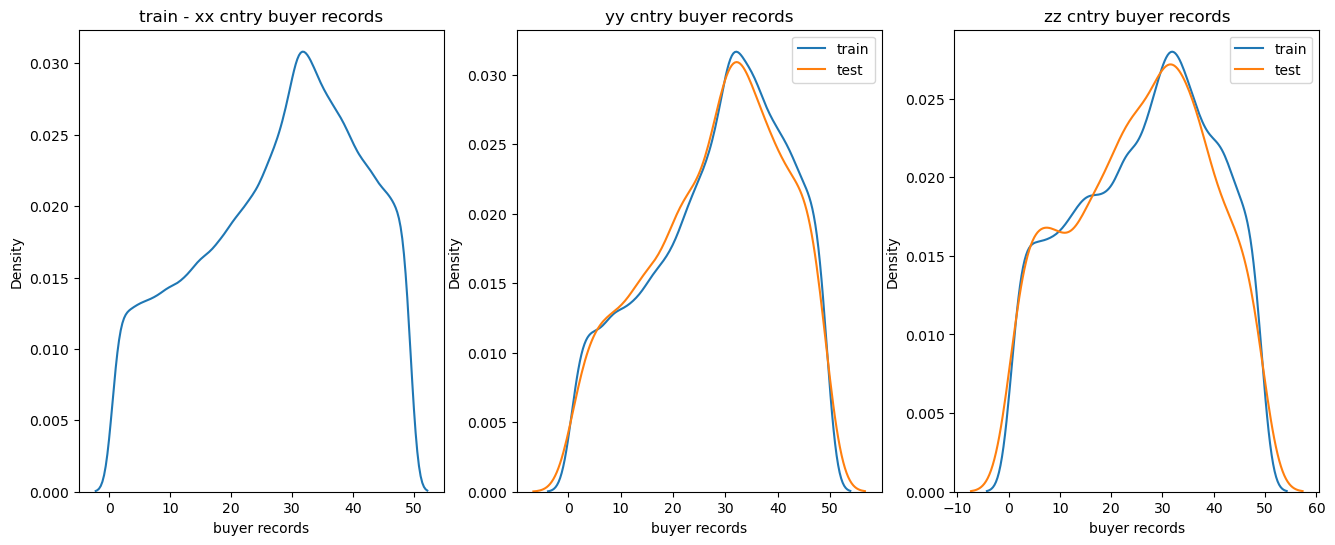

In [44]:
fig, ax = plt.subplots(1, 3 ,figsize=(16,6))
ax[0].set(xlabel='buyer records')
sns.kdeplot(admin_cnt[admin_cnt['count']<50].reset_index().query("is_train==1 and country_id=='xx'")['count'].values, ax=ax[0])\
    .set_title('train - xx cntry buyer records')

ax[1].set(xlabel='buyer records')
sns.kdeplot(admin_cnt[admin_cnt['count']<50].reset_index().query("is_train==1 and country_id=='yy'")['count'].values, ax=ax[1])\
    .set_title('yy cntry buyer records')
sns.kdeplot(admin_cnt[admin_cnt['count']<50].reset_index().query("is_train==0 and country_id=='yy'")['count'].values, ax=ax[1])
ax[1].legend(labels=['train', 'test'], loc="upper right")

ax[2].set(xlabel='buyer records')
sns.kdeplot(admin_cnt[admin_cnt['count']<50].reset_index().query("is_train==1 and country_id=='zz'")['count'].values, ax=ax[2])\
    .set_title('zz cntry buyer records')
sns.kdeplot(admin_cnt[admin_cnt['count']<50].reset_index().query("is_train==0 and country_id=='zz'")['count'].values, ax=ax[2])
ax[2].legend(labels=['train', 'test'], loc="upper right")

In [45]:
admin_cnt.columns = ['buyer_click_records_count', 'buyer_click_records_count_ratio']
admin_user_cnt = groupby_cnt_ratio(admin_cnt, 'buyer_click_records_count')
admin_user_cnt.columns = ['same_click_records_buyers_count', 'same_click_records_buyers_count_ratio']
admin_user_cnt.head()

same_click_records_buyers_count  \
is_train country_id buyer_click_records_count                                    
1        xx         31                                                    8231   
                    32                                                    7949   
                    33                                                    7832   
                    34                                                    7539   
                    30                                                    7314   

                                               same_click_records_buyers_count_ratio  
is_train country_id buyer_click_records_count                                         
1        xx         31                                                      0.016106  
                    32                                                      0.015554  
                    33                                                      0.015325  
                    34                                                      0.014752  
                    30                                                      0.014311

In [46]:
# xx cnt 
admin_user_cnt.reset_index().set_index("buyer_click_records_count")\
.query("is_train==1 and country_id=='xx'")[['same_click_records_buyers_count','same_click_records_buyers_count_ratio']].T

buyer_click_records_count,31,32,33,34,30,35,36,29,37,38,...,1287,1289,1292,1294,1299,1300,1301,1302,1304,1303
same_click_records_buyers_count,8231.000000,7949.000000,7832.000000,7539.000000,7314.000000,7191.000000,7148.000000,6896.000000,6831.000000,6805.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
same_click_records_buyers_count_ratio,0.016106,0.015554,0.015325,0.014752,0.014311,0.014071,0.013987,0.013494,0.013366,0.013315,...,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002


In [47]:
# yy cnt
admin_user_cnt.loc[([1,0],'yy',slice(None))].unstack(0).head(10)

same_click_records_buyers_count          \
is_train                                                           0       1   
country_id buyer_click_records_count                                           
yy         31                                                   82.0  1030.0   
           32                                                  119.0   995.0   
           33                                                   92.0   936.0   
           35                                                   77.0   934.0   
           36                                                   88.0   918.0   
           34                                                   95.0   911.0   
           30                                                   93.0   907.0   
           29                                                  104.0   834.0   
           37                                                   90.0   834.0   
           38                                                   67.0   820.0   

                                     same_click_records_buyers_count_ratio  \
is_train                                                                 0   
country_id buyer_click_records_count                                         
yy         31                                                     0.014724   
           32                                                     0.021368   
           33                                                     0.016520   
           35                                                     0.013827   
           36                                                     0.015802   
           34                                                     0.017059   
           30                                                     0.016700   
           29                                                     0.018675   
           37                                                     0.016161   
           38                                                     0.012031   

                                                
is_train                                     1  
country_id buyer_click_records_count            
yy         31                         0.017726  
           32                         0.017124  
           33                         0.016108  
           35                         0.016074  
           36                         0.015799  
           34                         0.015678  
           30                         0.015609  
           29                         0.014353  
           37                         0.014353  
           38                         0.014112

In [48]:
# zz cnt
admin_user_cnt.loc[([1,0],'zz',slice(None))].unstack(0).head(10)

same_click_records_buyers_count         \
is_train                                                           0      1   
country_id buyer_click_records_count                                          
zz         31                                                   70.0  760.0   
           32                                                   69.0  752.0   
           33                                                   73.0  716.0   
           34                                                   57.0  709.0   
           30                                                   82.0  705.0   
           35                                                   59.0  673.0   
           28                                                   55.0  653.0   
           29                                                   56.0  652.0   
           36                                                   73.0  643.0   
           37                                                   58.0  627.0   

                                     same_click_records_buyers_count_ratio  \
is_train                                                                 0   
country_id buyer_click_records_count                                         
zz         31                                                     0.016374   
           32                                                     0.016140   
           33                                                     0.017076   
           34                                                     0.013333   
           30                                                     0.019181   
           35                                                     0.013801   
           28                                                     0.012865   
           29                                                     0.013099   
           36                                                     0.017076   
           37                                                     0.013567   

                                                
is_train                                     1  
country_id buyer_click_records_count            
zz         31                         0.016596  
           32                         0.016421  
           33                         0.015635  
           34                         0.015482  
           30                         0.015395  
           35                         0.014696  
           28                         0.014259  
           29                         0.014237  
           36                         0.014041  
           37                         0.013691

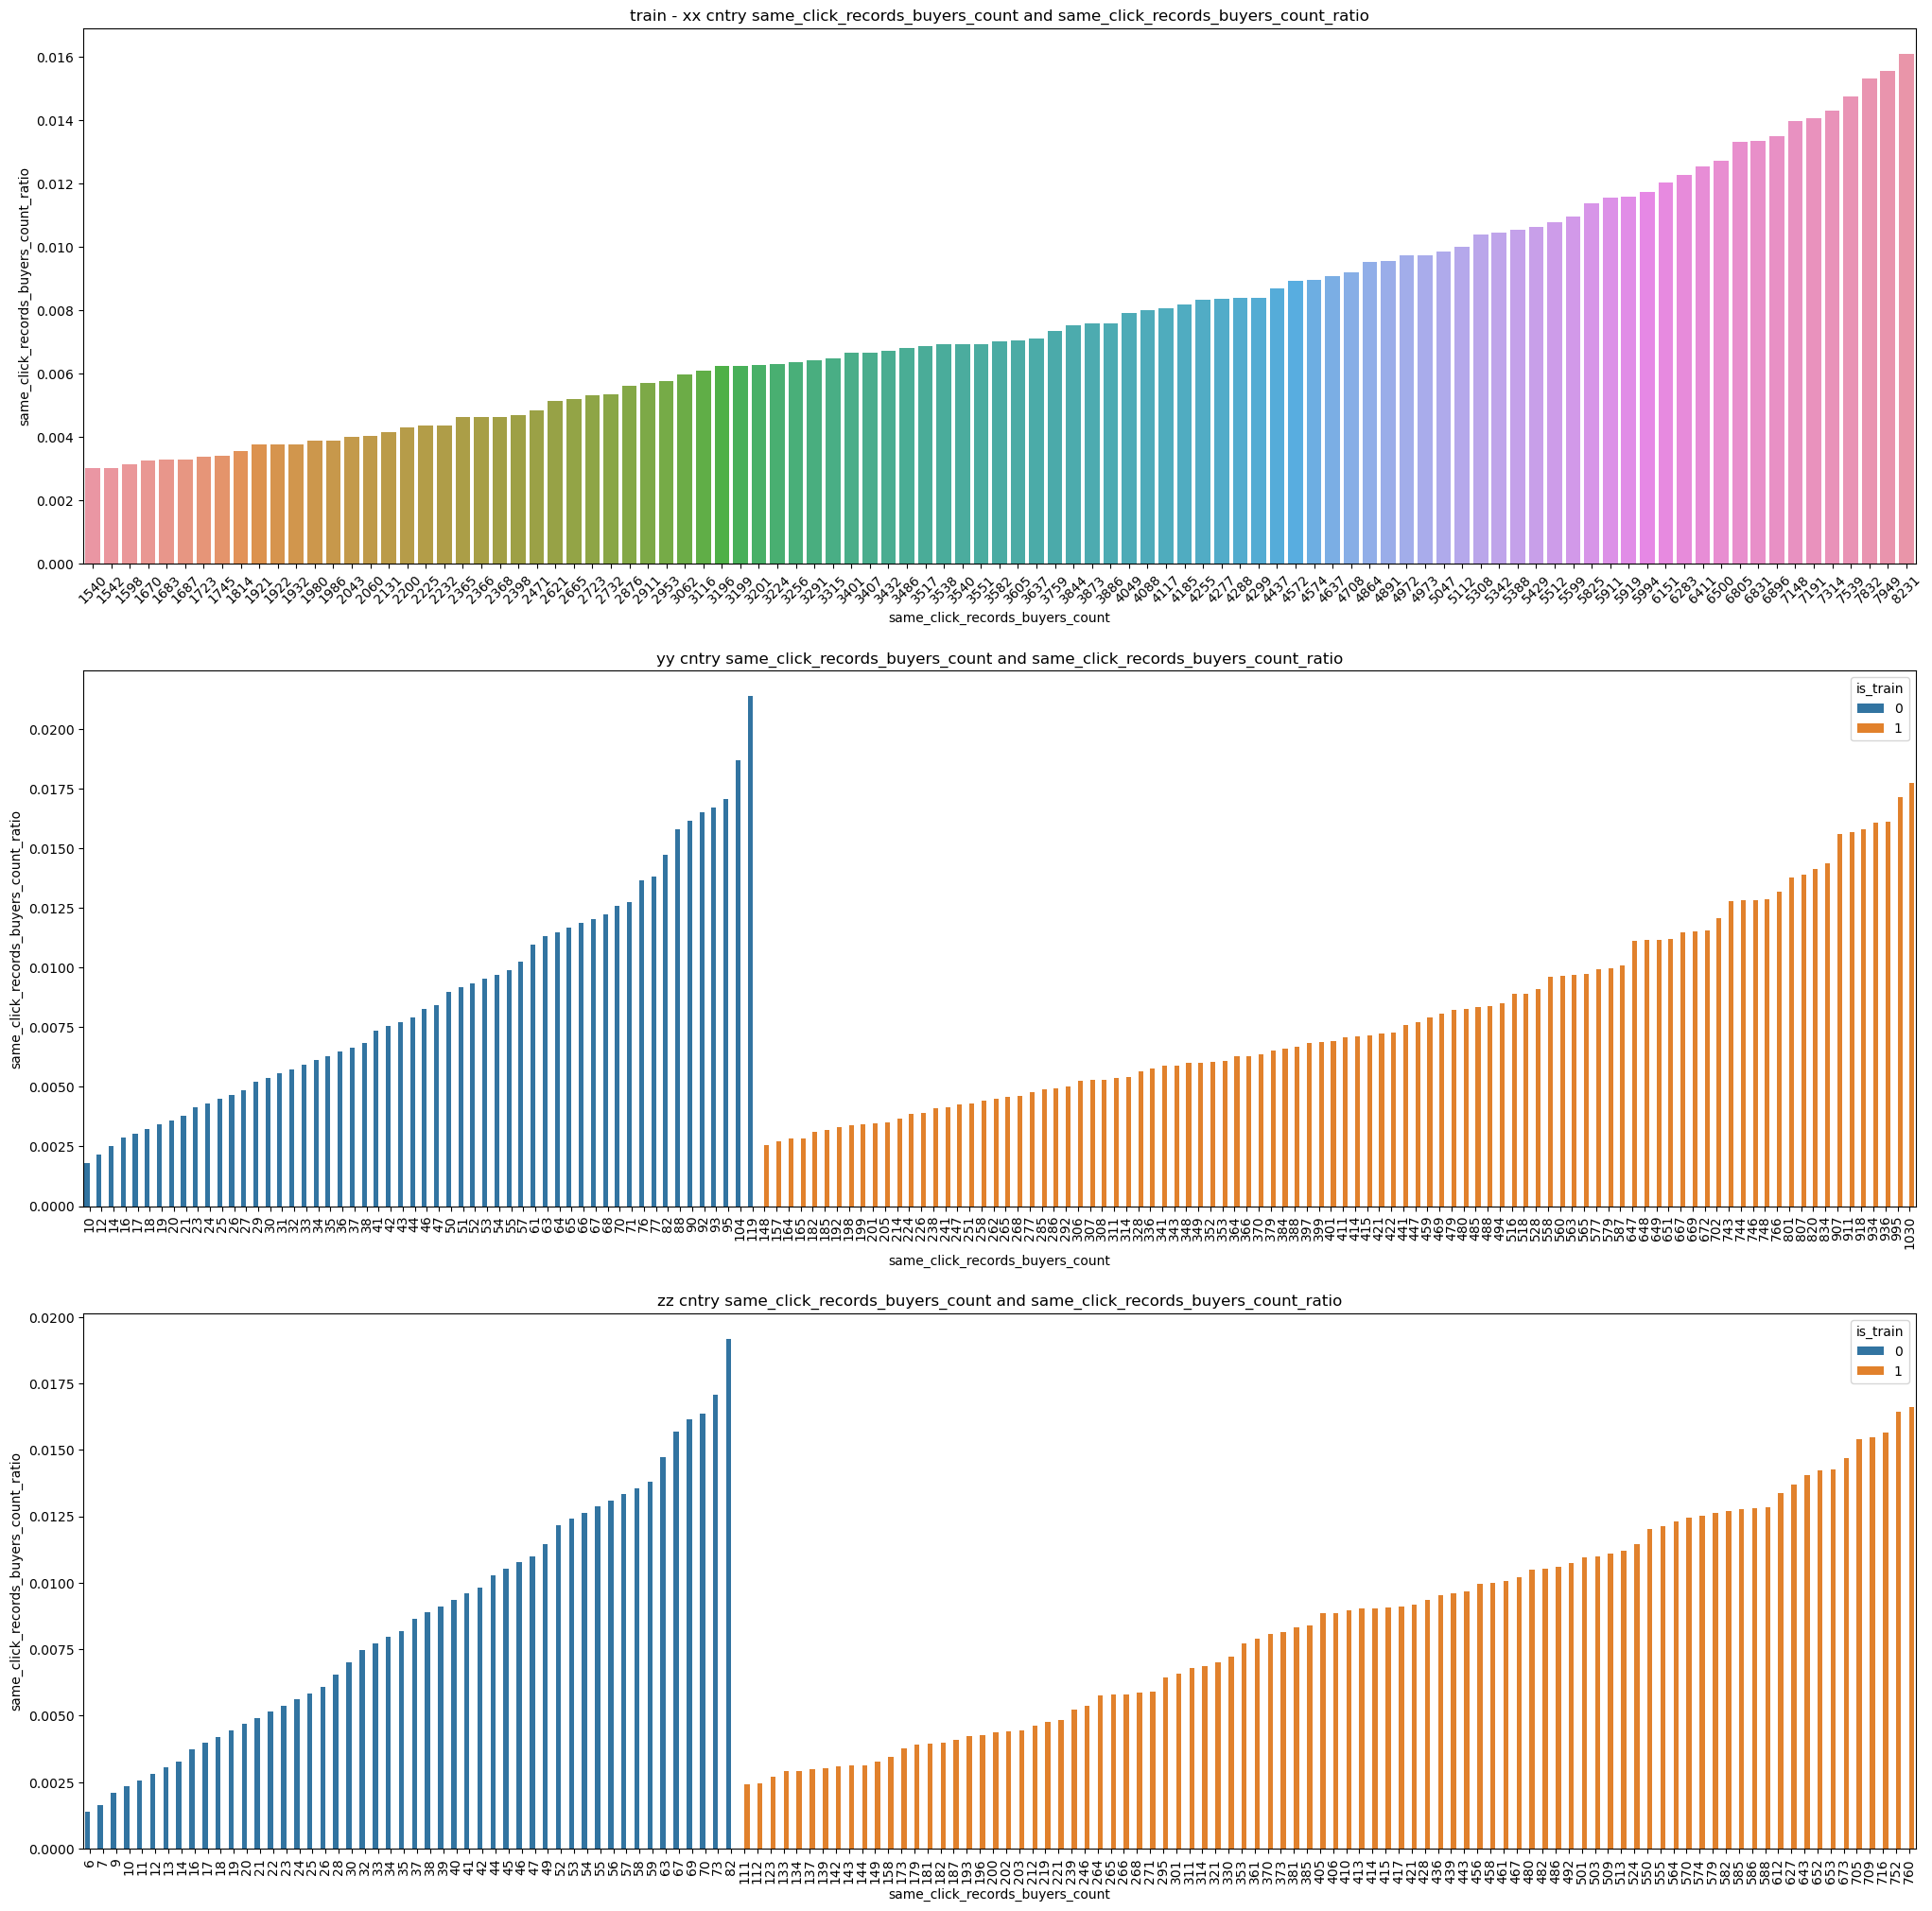

In [55]:
fig, ax = plt.subplots(3, 1, figsize=(25,25))
admin_plot = admin_user_cnt.reset_index()
sax = sns.barplot(x='same_click_records_buyers_count', y='same_click_records_buyers_count_ratio', \
            data=admin_plot[(admin_plot['buyer_click_records_count']<100) & (admin_plot['country_id']=='xx')], 
            estimator=np.mean, ax=ax[0])
_ = sax.set_title('train - xx cntry same_click_records_buyers_count and same_click_records_buyers_count_ratio')
sax.set_xticklabels(sax.get_xticklabels(), rotation=45)


sax = sns.barplot(x='same_click_records_buyers_count', y='same_click_records_buyers_count_ratio', hue='is_train', \
            data=admin_plot[(admin_plot['buyer_click_records_count']<100) & (admin_plot['country_id']=='yy')], 
            estimator=np.mean, ax=ax[1])
_ = sax.set_title('yy cntry same_click_records_buyers_count and same_click_records_buyers_count_ratio')
_ = sax.set_xticklabels(sax.get_xticklabels(), rotation=90)

sax = sns.barplot(x='same_click_records_buyers_count', y='same_click_records_buyers_count_ratio', hue='is_train', \
            data=admin_plot[(admin_plot['buyer_click_records_count']<100) & (admin_plot['country_id']=='zz')], 
            estimator=np.mean, ax=ax[2])
_ = sax.set_title('zz cntry same_click_records_buyers_count and same_click_records_buyers_count_ratio')
_ = sax.set_xticklabels(sax.get_xticklabels(), rotation=90)

In [56]:
print('商品表中商品数：',len(item['item_id'].unique()))
print('训练集中商品数：',len(df[train]['item_id'].unique()))
print('测试集中商品数：',len(df[test]['item_id'].unique()))
print('仅训练集有的商品数：',len(list(set(df[train]['item_id'].unique()).difference(set(df[test]['item_id'].unique())))))
print('仅测试集有的商品数：',len(list(set(df[test]['item_id'].unique()).difference(set(df[train]['item_id'].unique())))))
print('训练集测试集共同商品数：',len(list(set(df[train]['item_id'].unique()).intersection(set(df[test]['item_id'].unique())))))
print('训练集中不在商品表的商品数：',len(list(set(df[train]['item_id'].unique()).difference(set(item['item_id'].unique())))))
print('测试集中不在商品表的商品数：',len(list(set(df[test]['item_id'].unique()).difference(set(item['item_id'].unique())))))

商品表中商品数： 9139384
训练集中商品数： 9040941
测试集中商品数： 427137
仅训练集有的商品数： 8709140
仅测试集有的商品数： 95336
训练集测试集共同商品数： 331801
训练集中不在商品表的商品数： 27181
测试集中不在商品表的商品数： 1260


In [57]:
item_cnt = groupby_cnt_ratio(df.query("buy_flag==1"), 'item_id')
item_cnt.columns=['sales', 'sales_ratio']
item_cnt.reset_index(inplace=True)
item_cnt

,is_train,country_id,item_id,sales,sales_ratio
0,1,yy,8605056,181035,1.332777e-01
1,1,yy,2155121,172696,1.271386e-01
2,1,zz,3037355,86889,4.899491e-02
3,1,yy,3566108,82110,6.044927e-02
4,1,zz,5045592,66820,3.767842e-02
...,...,...,...,...,...
1209599,1,xx,6121463,1,1.907805e-07
1209600,1,xx,6121447,1,1.907805e-07
1209601,1,xx,6121422,1,1.907805e-07
1209602,1,xx,6121354,1,1.907805e-07


In [58]:
top_item_plot = item_cnt.groupby(['is_train','country_id']).head(10)
top_item_plot

,is_train,country_id,item_id,sales,sales_ratio
0,1,yy,8605056,181035,0.133278
1,1,yy,2155121,172696,0.127139
2,1,zz,3037355,86889,0.048995
3,1,yy,3566108,82110,0.060449
4,1,zz,5045592,66820,0.037678
5,1,zz,3993825,62991,0.035519
6,1,zz,6498038,58424,0.032944
7,1,yy,3654833,52389,0.038569
8,1,zz,1508459,45980,0.025927
9,1,zz,2217284,43892,0.024750


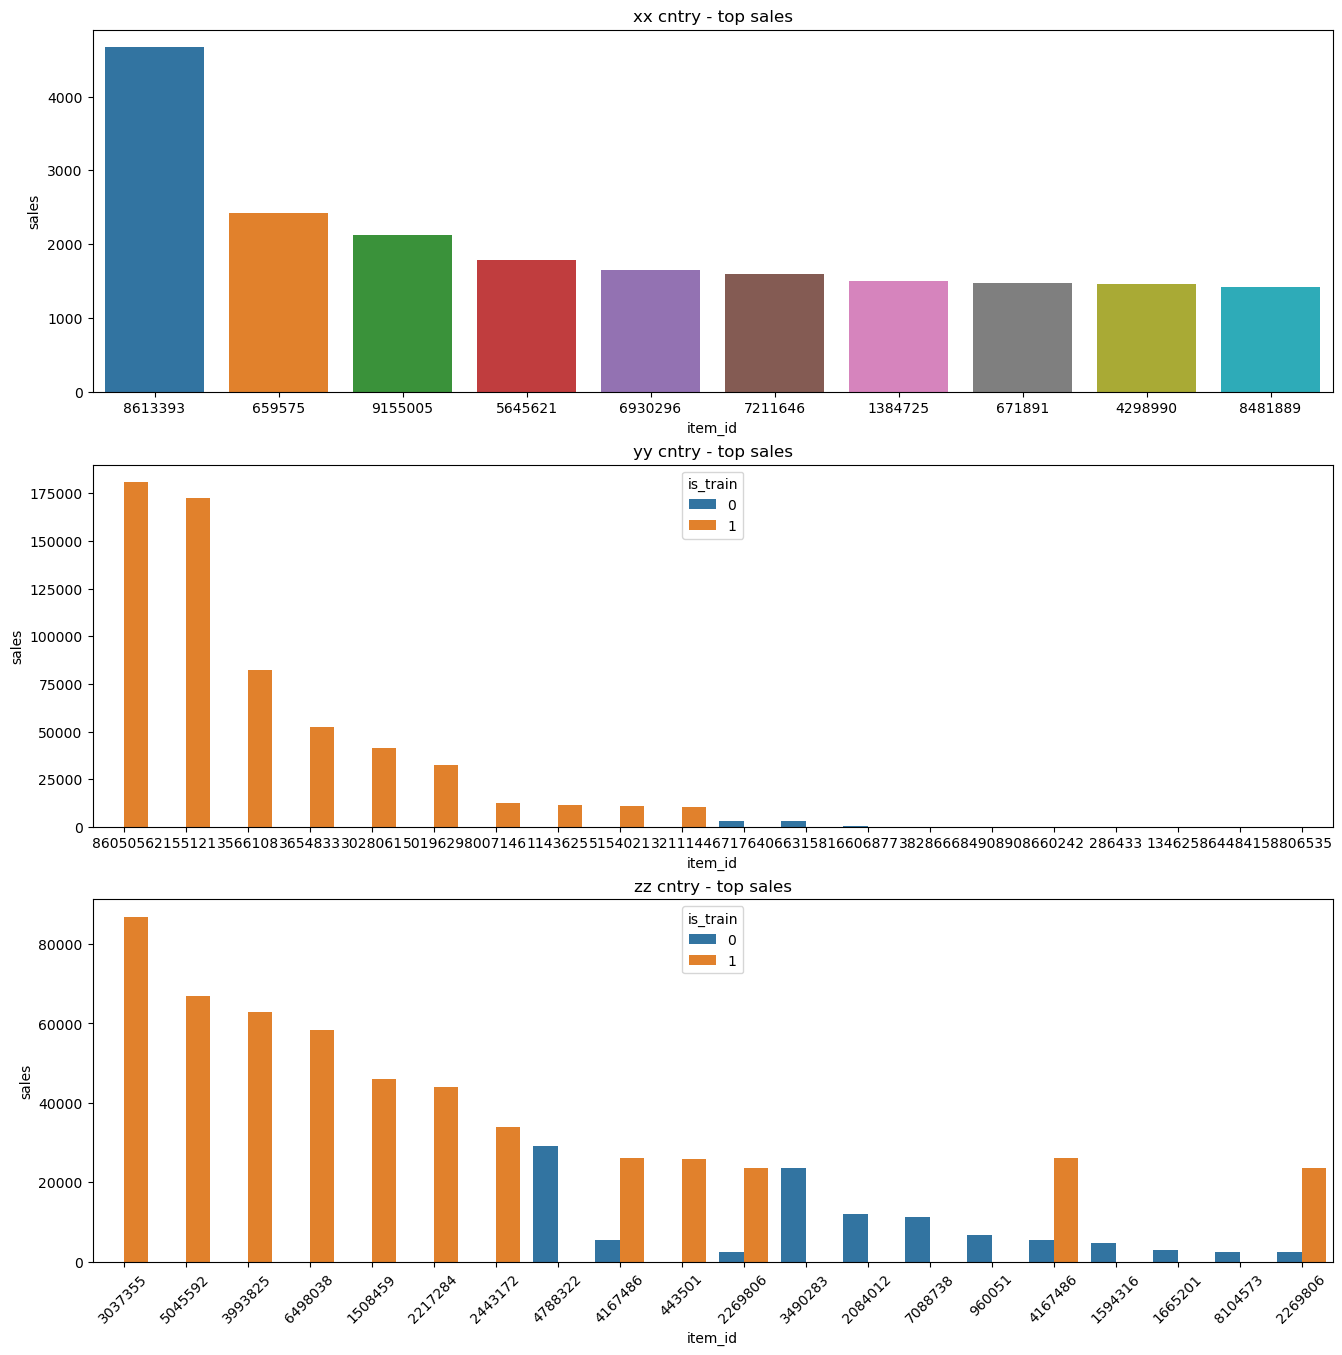

In [61]:
fig, ax = plt.subplots(3, 1, figsize=(16,16))
sns.barplot(x='item_id', y='sales', data=top_item_plot[top_item_plot['country_id']=='xx'], 
            order=top_item_plot['item_id'][top_item_plot['country_id']=='xx'], ax=ax[0], estimator=np.mean)\
    .set_title('xx cntry - top sales')

sns.barplot(x='item_id', y='sales', hue='is_train', data=top_item_plot[top_item_plot['country_id']=='yy'], 
            order=top_item_plot['item_id'][top_item_plot['country_id']=='yy'], ax=ax[1], estimator=np.mean)\
    .set_title('yy cntry - top sales')
_ = plt.xticks(rotation=45)

sns.barplot(x='item_id', y='sales', hue='is_train', data=top_item_plot[top_item_plot['country_id']=='zz'], 
            order=top_item_plot['item_id'][top_item_plot['country_id']=='zz'], ax=ax[2], estimator=np.mean)\
    .set_title('zz cntry - top sales')
_ = plt.xticks(rotation=45)

In [62]:
item_order_cnt = groupby_cnt_ratio(item_cnt, 'sales')
item_order_cnt.columns = ['sales_count', 'sales_count_ratio']
item_order_cnt

sales_count  sales_count_ratio
is_train country_id sales                                
1        xx         1           236704           0.276484
                    2           168127           0.196382
                    3           106352           0.124225
                    4            75212           0.087852
         yy         1            70028           0.371336
...                                ...                ...
                    6310             1           0.000005
                    7953             1           0.000005
                    10573            1           0.000005
                    10894            1           0.000005
         zz         86889            1           0.000007

[1557 rows x 2 columns]

In [63]:
item_order_cnt.groupby(['is_train','country_id']).head(5).sort_values(by=['country_id','is_train'])

sales_count  sales_count_ratio
is_train country_id sales                                
1        xx         1           236704           0.276484
                    2           168127           0.196382
                    3           106352           0.124225
                    4            75212           0.087852
                    5            49239           0.057514
0        yy         1             7492           0.405499
                    2             4242           0.229595
                    3             2266           0.122646
                    4             1411           0.076369
                    5              827           0.044761
1        yy         1            70028           0.371336
                    2            42489           0.225305
                    3            23619           0.125244
                    4            15470           0.082032
                    5             8513           0.045142
0        zz         1             5293           0.428063
                    2             2679           0.216660
                    3             1410           0.114032
                    4              851           0.068823
                    5              474           0.038334
1        zz         1            51984           0.387778
                    2            29194           0.217775
                    3            16031           0.119584
                    4            10206           0.076132
                    5             5519           0.041169

In [64]:
item_order_plot = item_order_cnt.reset_index()

xx_item_order_plot = item_order_plot[item_order_plot['country_id']=='xx']

yy_item_order_plot = item_order_plot[item_order_plot['country_id']=='yy']
yy_item_order_plot_1 = yy_item_order_plot[yy_item_order_plot['is_train']==1]
yy_item_order_plot_0 = yy_item_order_plot[yy_item_order_plot['is_train']==0]

zz_item_order_plot = item_order_plot[item_order_plot['country_id']=='zz']
zz_item_order_plot_1 = zz_item_order_plot[zz_item_order_plot['is_train']==1]
zz_item_order_plot_0 = zz_item_order_plot[zz_item_order_plot['is_train']==0]

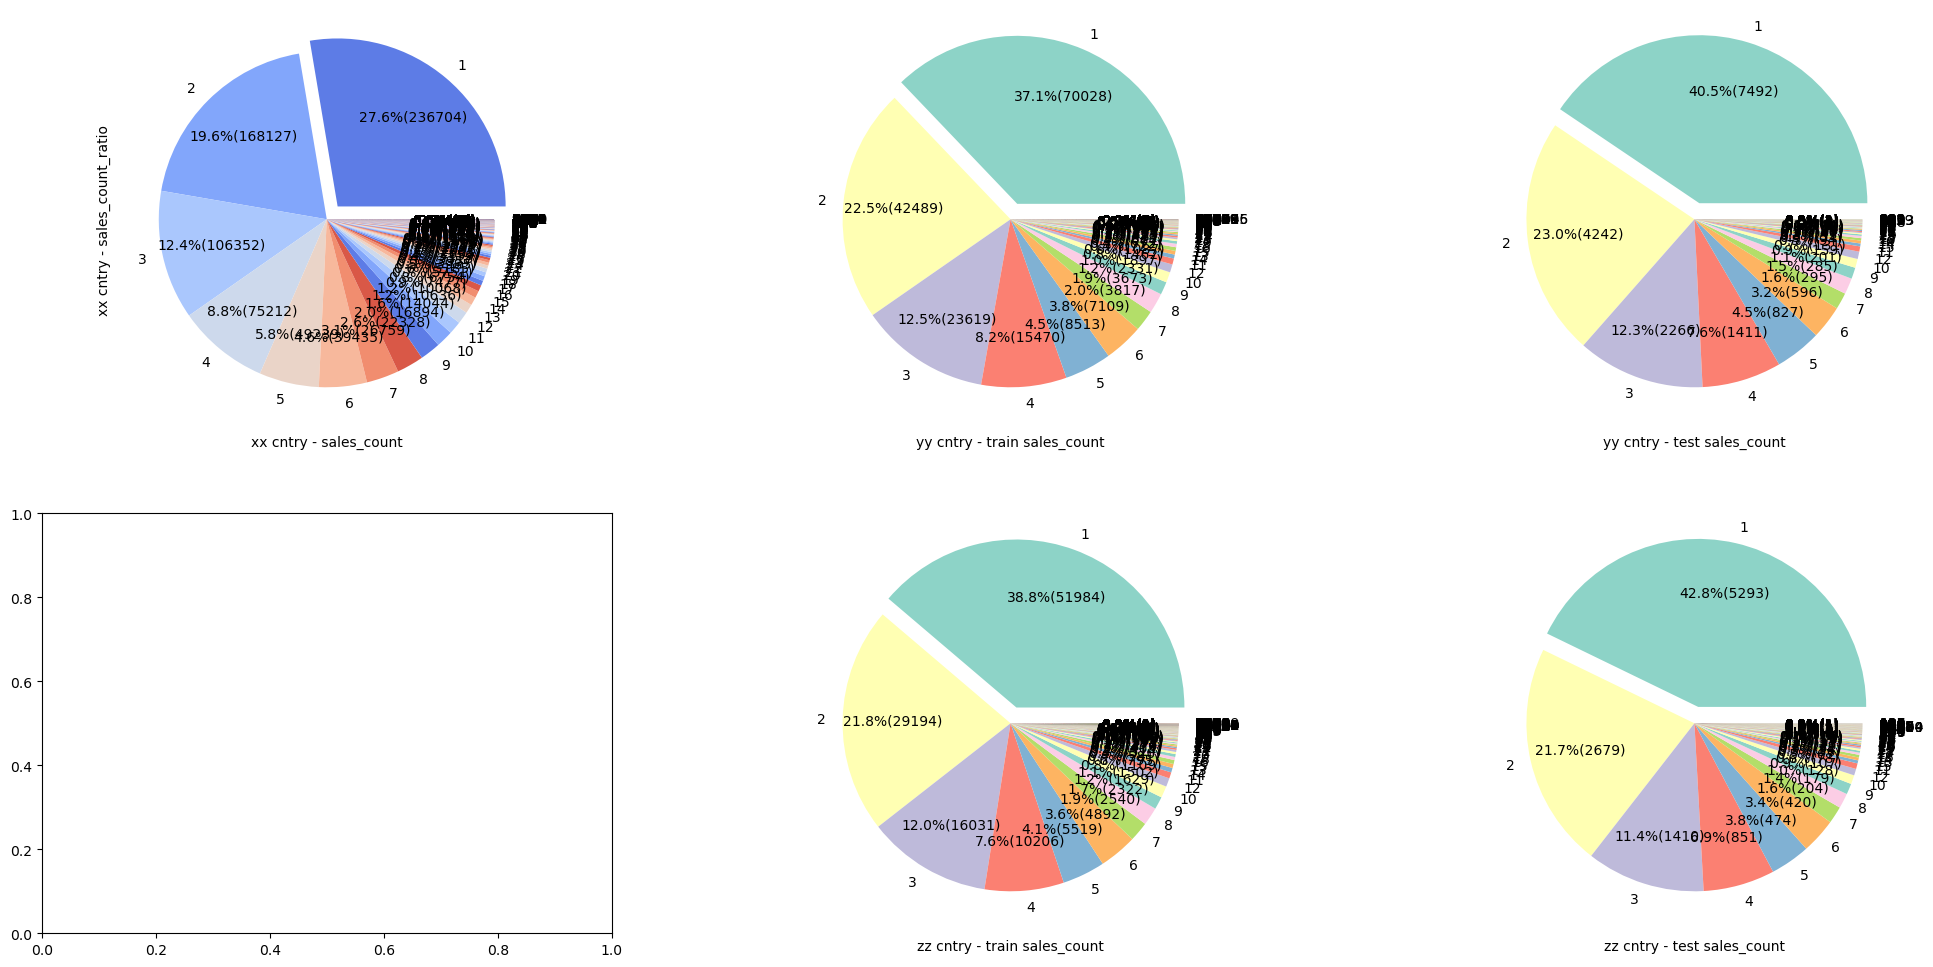

In [69]:
def text_style_func(pct, allvals):
    absolute = int(round(pct/100.*np.sum(allvals)))
    return "{:.1f}%({:d})".format(pct, absolute)

def pie_param(ax, df, color_palette):
    return ax.pie(df['sales_count_ratio'].values, \
                  autopct=lambda pct: text_style_func(pct, df['sales_count']), \
                  labels=df['sales'], explode=[0.1]+np.zeros(len(df)-1).tolist(), pctdistance=0.7, \
                  colors=sns.color_palette(color_palette, 8))

fig, ax = plt.subplots(2, 3, figsize=(25,12))

ax[0,0].set(xlabel='xx cntry - sales_count')
ax[0,0].set(ylabel='xx cntry - sales_count_ratio')
pie_param(ax[0,0], xx_item_order_plot, "coolwarm")

ax[0,1].set(xlabel='yy cntry - train sales_count')
pie_param(ax[0,1], yy_item_order_plot_1, "Set3")

ax[0,2].set(xlabel='yy cntry - test sales_count')
_ = pie_param(ax[0,2], yy_item_order_plot_0, "Set3")

ax[1,1].set(xlabel='zz cntry - train sales_count')
pie_param(ax[1,1], zz_item_order_plot_1, "Set3")

ax[1,2].set(xlabel='zz cntry - test sales_count')
_ = pie_param(ax[1,2], zz_item_order_plot_0, "Set3")

In [71]:
print(xx_item_order_plot.head(20)['sales_count_ratio'].sum())
print(yy_item_order_plot_1.head(20)['sales_count_ratio'].sum())
print(yy_item_order_plot_0.head(20)['sales_count_ratio'].sum())
print(zz_item_order_plot_1.head(20)['sales_count_ratio'].sum())
print(zz_item_order_plot_0.head(20)['sales_count_ratio'].sum())

0.9524145479095877
0.9841290883638062
0.9888504005195928
0.9762039744584352
0.9784067933683784


In [72]:
print('商品品类数', len(item['cate_id'].unique()))
print('训练集商品品类数', len(df[train]['cate_id'].unique()))
print('测试集商品品类数', len(df[test]['cate_id'].unique()))

商品品类数 4793
训练集商品品类数 4790
测试集商品品类数 3524


In [73]:
cate_cnt = item.groupby(['cate_id']).size().to_frame('count').reset_index()
cate_cnt.sort_values(by=['count'], ascending=False).head(5)

,cate_id,count
728,729,477556
1876,1877,247532
1317,1318,138341
1768,1769,106314
1875,1876,96784


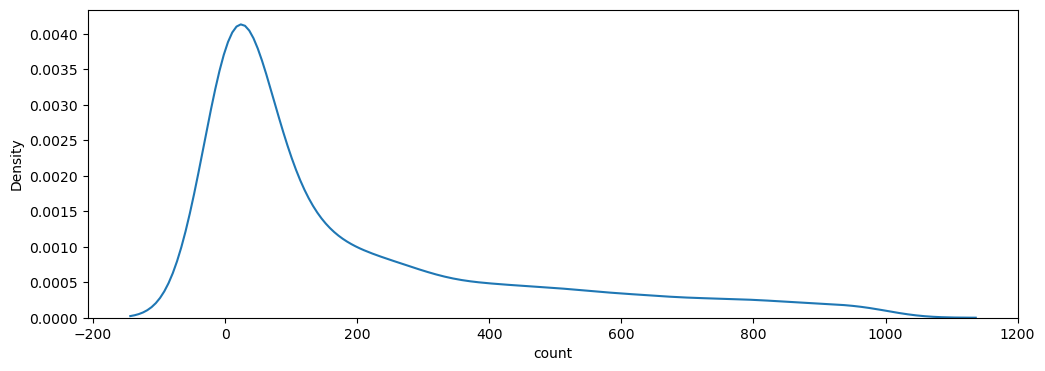

In [74]:
plt.figure(figsize=(12,4))
sns.kdeplot(data=cate_cnt[cate_cnt['count']<1000]['count']);

In [75]:
print('商品店铺数', len(item['store_id'].unique()))
print('训练集店铺数', len(df[train]['store_id'].unique()))
print('测试集店铺数', len(df[train]['store_id'].unique()))

商品店铺数 123617
训练集店铺数 122985
测试集店铺数 122985
